This notebook investigates how Mandarin children classify intransitive verbs. In world's languages, intransitive verbs can be categorized into at least two groups, unergative and unaccusative, based on the grammatical distribution and meaning. Most of the linguistic literature (Projectional approaches) propose the meaning of the verb is the most definitve factor of the above categorization, while some other studies (Constructional approaches) suggest the sentence a verb appears in can affect the categorization as well, but Constructional approaches received relatively less attention. In the current notebook, we leverage word2vec model to examine Constructional approaches, as well as how Constructional approaches can affect semantics in Projectional approaches. This is because Word2vec associates a word with the contextual environment and represent the semantics of a word in a vector. The semantic vectors allow for further comparison among multiple verbs, and the result of comparison can serve to observe the categorization of verbs based on the similarity and dissimilarity among verbs. To this end, we train a word2vec with children's CHILDES Mandarin corpus, and additional new verbs that do not exist in the CHILDES corpus. We add those new verbs into certain pre-selected sentences. Later, we compare the distance between new verbs, and existing verbs whose categories of unergative and unaccusative are confirmed (attested verbs). If some new verbs occurring in certain pre-selected sentences show similarity but the other show dissimilarity to the attested verbs,  this result reveals that pre-selected sentences verbs appear in can affect the categorization of unergative and unaccusative in languages, demonstrating Constructional approaches, as well as Constructional approaches can affect the result from Projectional approaches. We further manipulate the occurrence of sentences with new verbs, and also found that with more occurrences, the categorization of new verbs become more stable.

In [ ]:
# import Chinese segmentation library
!pip install jieba

In [ ]:
# turn off the enviroment variable to avoid hash randomization
import os
os.environ['PYTHONHASHSEED'] = str(0)

In [ ]:
# import libaries
import io
import re
import string
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras import layers
from xml.etree.ElementTree import parse
from xml.etree.ElementTree import fromstring
import jieba
import matplotlib.pyplot as plt
import random
import os

In [ ]:
# some functions that help examine the data (but many of them are not used in this notebook)
# check if the string contain Chinese characters
def is_contains_chinese(strs):
    for _char in strs:
        if '\u4e00' <= _char <= '\u9fa5':
            return True
    return False

# If the sentence contains only English, remove from the dataset
def cleaner(file):
  data=[]
  for sentence in file:
     if is_contains_chinese(sentence[0])==True:
        data.append([sentence])
  return data

# Removes English words in files
def english_remover(file):
  output=[]
  pattern = re.compile(r'[^\u4e00-\u9fa5]')
  for sentence in file:
    temp_sentence=[]
    for word in sentence:
            chinese = re.sub(pattern,'', word)
            temp_sentence.append(chinese)
    output.append(temp_sentence)
  return output

# Clean empty lists in files
def list_cleaner(document):
  data=[]
  for file in document:
      for sentence in file:
          if sentence==['']:
              continue
          elif sentence==[]:
              continue
          else:
             sentence=''.join(sentence)
             data.append([sentence])
  return data

#define a function which extracts the Chinese words in the database.
#This database has been preprocessed so it includes information of each word, e.g. the meaning of the words, the grammatical function of the words...
# We only want the Chinese words, but we don't want other information of the word.
def XMLreader(filename=''):
  tree = parse(filename)
  root = tree.getroot()
  file=[]
  sentence=[]
  for elem in root:
      for gchild in elem:
                if gchild.text==None:
                    file.append(sentence)
                    sentence=[]
                    continue
                else:
                    sentence.append(gchild.text)
  file=english_remover(file)
  return file

# Read the file
def read_text_file(file_path):
 os.chdir(file_path)
 final_file=[]
 # iterate through all file
 for file in os.listdir(file_path):
    if os.path.isdir(file)==True:
      file_path_new=file_path+"/"+file
      for file in os.listdir(file_path_new):
        if file.startswith("."):
            continue
        if file.endswith(".xml"):
            document = f"{file_path_new}"+"/"+file
        # call read text file function
            with open(document, 'r', encoding="utf8", errors="ignore") as f:
               final_file.append(XMLreader(f))
    # Check whether file is in text format or not
    else:
        if file.startswith("."):
            continue
        if file.endswith(".xml"):
            document = f"{file_path}"+"/"+file
        # call read text file function
            with open(document, 'r', encoding="utf8", errors="ignore") as f:
               final_file.append(XMLreader(f))
 return final_file

# Tokenize words in data
def tokenize (data):
  list_tokenized=[]
  for sentence in data:
    if sentence=='], [':
       continue
    else:
      a=tokenizer_bert.encode(sentence[0])
      if len(a)<4:
        continue
      elif len(a)>50:
        continue
      else:
       list_tokenized.append(a)
  return list_tokenized

def find_the_key(dictionary, word):
  for key, value in dictionary.items():
      if value == word:
         return key

def create_dictionary(data):
  res = []
  for sentence in data:
        [res.append(x) for x in sentence if x not in res]
  dictionary2={v+1: k for v, k in enumerate(dictionary)}
  return dictionary2, res

def convert_sentence(X, dictionary):
  X_converted=[]
  for sentence in X:
      coverted_sentence=[]
      print(sentence)
      for word in sentence:
          if word==0:
              coverted_sentence.append(word)
          elif word==102:
              found_key = find_the_key(dictionary, word)
              coverted_sentence.append(found_key)
            # coverted_sentence=[]
          else:
              found_key = find_the_key(dictionary, word)
              coverted_sentence.append(found_key)
      X_converted.append(coverted_sentence)
  return X_converted

def find_the_value(dictionary, word):
  for key, value in dictionary.items():
      if key == word:
         return value

def search_word_result(search_word, clean_data, search_word2=None):
    result=0
    if search_word2 != None:
        search_word=search_word+search_word2
    for list_data in clean_data:
        if search_word in list_data[0]:
                result=1
                break
        else:
                continue
    return result
def create_jieba_dictionary(data):
  res = []
  for sentence in data:
        [res.append(x) for x in sentence if x not in res]
  dictionary = {index+3 : item for index, item in enumerate(res)}
  return dictionary

def find_jieba_key(dictionary, word):
  for key, value in dictionary.items():
      if value == word:
         return key
def convert_jieba_sentence(X, dictionary):
  X_converted=[]
  for sentence in X:
      converted_sentence=[]
      converted_sentence.append(1)
      for word in sentence:
            found_key=find_jieba_key(dictionary, word)
            converted_sentence.append(found_key)
      converted_sentence.append(2)
      X_converted.append(converted_sentence)
  return X_converted

In [ ]:
# import the CHILDES Mandarin database. We only include Taiwanese Mandanrin for reducing unwanted effects from unknown factors.
#https://drive.google.com/drive/folders/1BEJb5MiHt0WUESU-iy87c7wGnE_3tHB0?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/Chang1/"
Chang1=read_text_file(project_folder)
#https://drive.google.com/drive/folders/1NhIS1rK28mYwShDFtr3pR2ZzPhqaiSxE?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/Chang2-BookReading"
Chang2_BookReading=read_text_file(project_folder)
#https://drive.google.com/drive/folders/103UeToh-hshQCe7X1aRo-xcoYvJRAlZJ?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/Chang2-Anecdote/"
Chang2_Anecdote=read_text_file(project_folder)
#https://drive.google.com/drive/folders/1Ga-TV3bV8NPvFSzVtXJC62hI6GkRdVFJ?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/ChangPlay/"
ChangPlay=read_text_file(project_folder)
#https://drive.google.com/drive/folders/1mThdlrQ2u-vq8x6dlDuW9VZMWYJq2mVg?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/ChangPN/"
ChangPN=read_text_file(project_folder)
#https://drive.google.com/drive/folders/1OQQwKBm73UVIYWdfZm5MKUMg1q-gLgXm?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/TCCM/"
TCCM=read_text_file(project_folder)
#https://drive.google.com/drive/folders/11azb4ZDbOHkxsN2JqkeigpREW8SHWSLF?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/TCCM-reading/"
TCCMreading=read_text_file(project_folder)
#project_folder = "/home/kylin/data/ZhouNarratives"
#os.chdir(project_folder)

In [ ]:
#Merge all the subsets of data into one variable
clean_data_taiwan_before=list_cleaner(Chang1)+list_cleaner(Chang2_Anecdote)+list_cleaner(ChangPlay)+list_cleaner(Chang2_BookReading)+list_cleaner(ChangPN)+list_cleaner(TCCMreading)+list_cleaner(TCCM)

In [ ]:
def count_word (data):
    count=[]
    for sentence in data:
        count.append(len(sentence[0]))
    return np.sum(count)

In [ ]:
count_word(clean_data_taiwan_before)

845639

In [ ]:
# A function which generates sentences and randomize nouns in those sentences
# This function will generate 11 types of pre-selected sentences with each type having two new verbs, i.e., in total 22 sentences.
# K is the number of each sentence in the training data
def generate_sentences (k):
  subjects=['哥哥', '小狗', '兎子', '鱼', '一个人', '老師', '学生', '父亲', '母亲', '男生', '女生', '朋友', '家人', '人', '动物', '小猫', '弟弟', '妹妹', '爸爸', '妈妈', '店员', '客人', '医生', '狮子', '姊姊', '同学', '小孩', '邻居', '同事', '老虎', '老人', '儿子', '女儿']
  objects=['一个球', '水果', '笔', '食物', '东西', '玩具', '饭', '手', '紙', '头发']
  location=['家里', '外面', '学校', '教室', '车站', '车上', '厕所', '路上', '里面', '公园']
  #type 1: locative inversion, i.e., location+"verb"+perfective marker+subject
  lvs_1=[]
  for i in range(0, k):
    j=i
    if j >9:
        j=j//10
        lvs_1.append([f'{location[j]}物语了{subjects[i]}'])
  lvs_2=[]
  for i in range(0, k):
    j=i
    if j >9:
        j=j//10
        lvs_2.append([f'{location[j]}发霉了{subjects[i]}'])
  #type 2: resultative (2nd), i.e., subject+transitive verb+"verb"+perfective marker+object
  resultative_1=[]
  for i in range(0, k):
    j=i
    if j >9:
        j=j//10
        resultative_1.append([f'{subjects[i]}放民主了{objects[j]}'])
  resultative_2=[]
  for i in range(0, k):
    j=i
    if j >9:
        j=j//10
        resultative_2.append([f'{subjects[i]}拿协约了{objects[j]}'])
  #type 3: ba (a marker to stress the object) sentence, i.e. subject+ba+object+transitive verb+"verb"+perfective marker
  ba_1=[]
  for i in range(0, k):
    j=i
    if j >9:
        j=j//10
        ba_1.append([f'{subjects[i]}把{objects[j]}拿法律了'])
  ba_2=[]
  for i in range(0, k):
    j=i
    if j >9:
      j=j//10
      ba_2.append([f'{subjects[i]}把{objects[j]}放节约了'])
  # type 4: null subject perfective, i.e., (null subject)+"verb"+ perfective marker
  le_null_1=[['偿还了!']]*k
  le_null_2=[['求偿了!']]*k
  # type 5: perfective marker, i.e., subject+"verb"+perfective marker
  le_1=[]
  for i in range(0, k):
    le_1.append([f'{subjects[i]}博爱了'])
  le_2=[]
  for i in range(0, k):
    le_2.append([f'{subjects[i]}发酵了'])
  #type 6: resultative(1st), i.e. subject+"verb"+verb1+perfective marker
  v_complement_1=[]
  for i in range(0, k):
    v_complement_1.append([f'{subjects[i]}报偿出來了'])
  v_complement_2=[]
  for i in range(0, k):
    v_complement_2.append([f'{subjects[i]}宴席出來了'])
  #type 7: resultative (1st), i.e., subject+"verb"+verb1+perfective marker
  resultative_no_subject_1=[['蛋白掉了']]*k
  resultative_no_subject_2=[['支持走了']]*k
  #type 8: model verb "will", i.e., subject+ will + "verb"
  hui_1=[]
  for i in range(0, k):
    hui_1.append([f'{subjects[i]}一直会疲劳'])
  hui_2=[]
  for i in range(0, k):
    hui_2.append([f'{subjects[i]}一直会砚台'])
  #type 9: durative marker, i.e., subject+"verb"+durative marker
  zhe_1=[]
  for i in range(0, k):
    zhe_1.append([f'{subjects[i]}和约着'])
  zhe_2=[]
  for i in range(0, k):
    zhe_2.append([f'{subjects[i]}现况着'])
  #type 10: want_V, i.e. subject+want_to+"verb"
  want_v_1=[]
  for i in range(0, k):
    want_v_1.append([f'{subjects[i]}想软膏'])
  want_v_2=[]
  for i in range(0, k):
    want_v_2.append([f'{subjects[i]}想矫正'])
  #type 11: imperf+V, i.e. subject+always+imperfective marker+"verb"
  keep_ving_1=[]
  for i in range(0, k):
    keep_ving_1.append([f'{subjects[i]}一直在经济'])
  keep_ving_2=[]
  for i in range(0, k):
    keep_ving_2.append([f'{subjects[i]}一直在结构'])

  return lvs_1+lvs_2+resultative_1+\
  resultative_2+keep_ving_1+keep_ving_2+want_v_1+want_v_2+le_1+le_2+zhe_1+zhe_2+v_complement_1+v_complement_2+\
  ba_1+ba_2+le_null_1+le_null_2+resultative_no_subject_1+resultative_no_subject_2+hui_1+hui_2


In [ ]:
# A function which generates sentences and randomize nouns in those sentences
# This function will generate 11 types of pre-selected sentences with each type having two new verbs, i.e., in total 22 sentences.
# K is the number of each sentence in the training data
def generate_sentences (k):
  subjects=['哥哥', '小狗', '兎子', '鱼', '一个人', '老師', '学生', '父亲', '母亲', '男生', '女生', '朋友', '家人', '人', '动物', '小猫', '弟弟', '妹妹', '爸爸', '妈妈', '店员', '客人', '医生', '狮子', '姊姊', '同学', '小孩', '邻居', '同事', '老虎', '老人', '儿子', '女儿']
  objects=['一个球', '水果', '笔', '食物', '东西', '玩具', '饭', '手', '紙', '头发']
  location=['家里', '外面', '学校', '教室', '车站', '车上', '厕所', '路上', '里面', '公园']
  #type 1: locative inversion, i.e., location+"verb"+perfective marker+subject
  lvs_1=[]
  for i in range(0, k):
    lvs_1.append([f'{random.choice(location)}物语了{random.choice(subjects)}'])
  lvs_2=[]
  for i in range(0, k):
    lvs_2.append([f'{random.choice(location)}发霉了{random.choice(subjects)}'])
  #type 2: resultative (2nd), i.e., subject+transitive verb+"verb"+perfective marker+object
  resultative_1=[]
  for i in range(0, k):
    resultative_1.append([f'{random.choice(subjects)}放民主了{random.choice(objects)}'])
  resultative_2=[]
  for i in range(0, k):
    resultative_2.append([f'{random.choice(subjects)}拿协约了{random.choice(objects)}'])
  #type 3: ba (a marker to stress the object) sentence, i.e. subject+ba+object+transitive verb+"verb"+perfective marker
  ba_1=[]
  for i in range(0, k):
    ba_1.append([f'{random.choice(subjects)}把{random.choice(objects)}拿法律了'])
  ba_2=[]
  for i in range(0, k):
    ba_2.append([f'{random.choice(subjects)}把{random.choice(objects)}放节约了'])
  # type 4: null subject perfective, i.e., (null subject)+"verb"+ perfective marker
  le_null_1=[['偿还了!']]*k
  le_null_2=[['求偿了!']]*k
  # type 5: perfective marker, i.e., subject+"verb"+perfective marker
  le_1=[]
  for i in range(0, k):
    le_1.append([f'{random.choice(subjects)}博爱了'])
  le_2=[]
  for i in range(0, k):
    le_2.append([f'{random.choice(subjects)}发酵了'])
  #type 6: resultative(1st), i.e. subject+"verb"+verb1+perfective marker
  v_complement_1=[]
  for i in range(0, k):
    v_complement_1.append([f'{random.choice(subjects)}报偿出來了'])
  v_complement_2=[]
  for i in range(0, k):
    v_complement_2.append([f'{random.choice(subjects)}宴席出來了'])
  #type 7: resultative (1st), i.e., subject+"verb"+verb1+perfective marker
  resultative_no_subject_1=[['蛋白掉了']]*k
  resultative_no_subject_2=[['支持走了']]*k
  #type 8: model verb "will", i.e., subject+ will + "verb"
  hui_1=[]
  for i in range(0, k):
    hui_1.append([f'{random.choice(subjects)}一直会疲劳'])
  hui_2=[]
  for i in range(0, k):
    hui_2.append([f'{random.choice(subjects)}一直会砚台'])
  #type 9: durative marker, i.e., subject+"verb"+durative marker
  zhe_1=[]
  for i in range(0, k):
    zhe_1.append([f'{random.choice(subjects)}和约着'])
  zhe_2=[]
  for i in range(0, k):
    zhe_2.append([f'{random.choice(subjects)}现况着'])
  #type 10: want_V, i.e. subject+want_to+"verb"
  want_v_1=[]
  for i in range(0, k):
    want_v_1.append([f'{random.choice(subjects)}想软膏'])
  want_v_2=[]
  for i in range(0, k):
    want_v_2.append([f'{random.choice(subjects)}想矫正'])
  #type 11: imperf+V, i.e. subject+always+imperfective marker+"verb"
  keep_ving_1=[]
  for i in range(0, k):
    keep_ving_1.append([f'{random.choice(subjects)}一直在经济'])
  keep_ving_2=[]
  for i in range(0, k):
    keep_ving_2.append([f'{random.choice(subjects)}一直在结构'])

  return lvs_1+lvs_2+resultative_1+\
  resultative_2+keep_ving_1+keep_ving_2+want_v_1+want_v_2+le_1+le_2+zhe_1+zhe_2+v_complement_1+v_complement_2+\
  ba_1+ba_2+le_null_1+le_null_2+resultative_no_subject_1+resultative_no_subject_2+hui_1+hui_2


In [ ]:
# Define a function that can search for a word in the data
def search_word(search_word, clean_data):
    matching=[]
    matching_index=[]
    for i, list_data in enumerate(clean_data):
            if search_word in list_data:
                matching.append(list_data)
                matching_index.append(i)
    return matching, matching_index

In [ ]:
# Experiment 1: When the occurrence of each new verb is only 4, there are 4 occurrences for each new verb, and 8 occurrences for each sentence type.
cosine_loss=tf.keras.losses.CosineSimilarity(axis=-1, name='cosine_similarity')
# verbs that we know the category of, and that appear in the diagnostic sentence in the corpus (attested unaccusative verbs)
verb_in_list=['掉','来']

# Search for attested unergative verbs in the corpus
verb_list=['融化', '流', '掉', '死', '到', '下', '逃', '丢', '关', '开', '来', '跑掉', '打死', '弄掉', '沉下去', '跑过来', '下来', '上去', '走掉', '飞走', '跳', '飞', '哭', '玩']
cosine_loss=tf.keras.losses.CosineSimilarity(axis=-1, name='cosine_similarity')

# the attested unergative verbs should occur with the string '着' in the corpus
search_strings='着'

# search attested unergative verbs which occur string '着' in the corpus
search_result=[]
for word in verb_list:
    word = word+search_strings
    search_result.append(search_word_result(word,  clean_data_taiwan_before))
search_result_index= [i for i, j in enumerate(search_result) if j == 1]

#get attested unergative verbs
verb_in_list_asp=[]
for index in search_result_index:
    verb_in=verb_list[index]
    verb_in_list_asp.append(verb_in)

times=0
final_verb_loss_before=[]
final_verb_loss_before_asp=[]

def hash(astring):
  return ord(astring[0])

# We train the model 20 times to get the mean of the cosine similarity losses of new verbs. This can ensure the results are stable.
while times !=20:
    clean_data_taiwan_nonce_simple_before=clean_data_taiwan_before+generate_sentences(4)
    jieba_data_nonce_simple_before=[]
  # segment sentences into words
    for sentence in clean_data_taiwan_nonce_simple_before:
      seg_list = jieba.lcut(sentence[0])
      jieba_data_nonce_simple_before.append(seg_list)
  # initialize word2vec model and set deterministic parameters
    model_simple_before=Word2Vec(window=5, min_count=3, workers=1, hashfxn=hash)
    model_simple_before.build_vocab(jieba_data_nonce_simple_before)
  # train the model
    model_simple_before.train(jieba_data_nonce_simple_before, total_examples=model_simple_before.corpus_count, epochs=model_simple_before.epochs)
  # all the new verbs in the training data
    #gramma_sentences_nonce=['物语','发霉', '民主','协约', '经济','结构','软膏','矫正', '发酵', '博爱', '和约', '现况', '报偿', '宴席', '法律', '节约', '偿还', '求偿', '支持', '蛋白', '砚台', '疲劳']
    gramma_sentences_nonce=['物语','发霉', '民主','协约', '法律', '节约', '偿还', '求偿', '发酵', '博爱', '报偿', '宴席',  '支持', '蛋白', '砚台', '疲劳', '和约', '现况','软膏','矫正', '经济','结构']
  # create an unaccusative matrix that memorizes all the cosine similarity losses between new verbs and attested unaccusative verbs
    loss_nonce_before=np.zeros(shape=(len(verb_in_list), len(gramma_sentences_nonce)))
    for i in range(len(verb_in_list)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=(-1)*cosine_loss(model_simple_before.wv[verb_in_list[i]], model_simple_before.wv[gramma_sentences_nonce[k]]).numpy()
             #print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_before[i,k]=loss_temp
    loss_nonce_before=pd.DataFrame(loss_nonce_before)

    # create an unergative matrix that memorizes all the cosine similarity losses between new verbs and attested unergative verbs
    loss_nonce_before_asp=np.zeros(shape=(len(verb_in_list_asp), len(gramma_sentences_nonce)))
    for i in range(len(verb_in_list_asp)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=(-1)*cosine_loss(model_simple_before.wv[verb_in_list_asp[i]], model_simple_before.wv[gramma_sentences_nonce[k]]).numpy()
             #print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_before_asp[i,k]=loss_temp
    loss_nonce_before_asp=pd.DataFrame(loss_nonce_before_asp)
    # get the mean for each new verb in the unergative matrix
    verb_loss_before_asp=np.mean(loss_nonce_before_asp, axis=0)
    final_verb_loss_before_asp.append(verb_loss_before_asp)
    # get the mean for each new verb in the unaccusative matrix
    verb_loss_before=np.mean(loss_nonce_before, axis=0)
    final_verb_loss_before.append(verb_loss_before)
    # print the mean of each new verb
    #for i in range(len(verb_loss_before)):
    #    print(f"average cosine similarity for {gramma_sentences_nonce[i]} is", verb_loss_before[i])
    times= times+1

# get the mean and the standard deviation of each verb in 20 times (in the unaccusative matrix). These numbers would be used later for plotting.
final_verb_loss_mean_before=np.mean(final_verb_loss_before, axis=0)
std_before=np.std(final_verb_loss_before, axis=0)
# get the mean and the standard deviation of each verb in 20 times (in the unergative matrix). These numbers would be used later for plotting.
final_verb_mean_loss_asp_before=np.mean(final_verb_loss_before_asp, axis=0)
std_asp_before=np.std(final_verb_loss_before_asp, axis=0)
#print(std_before)
#for i in range(len(final_verb_loss_mean_before)):
#    print(f"average cosine similarity after training {times} times for {gramma_sentences_nonce[i]} is", final_verb_loss_mean_before[i])


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.111 seconds.
DEBUG:jieba:Loading model cost 1.111 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
# Experiment 2: When the occurrence of each new verb is 8, there are 8 occurrences for each new verb, and 16 occurrences for each sentence type.

# attested unergative/unaccusative verbs are the same as in the previous experiment.
times=0
final_verb_loss_middle=[]
final_verb_loss_middle_asp=[]

def hash(astring):
  return ord(astring[0])

# We train the mdoel 20 times to get the mean of the cosine similarity losses of new verbs. This can ensure the results are stable.
while times !=20:
    clean_data_taiwan_nonce_simple_middle=clean_data_taiwan_before+generate_sentences(8)
    jieba_data_nonce_simple_middle=[]
     # segment sentences into words
    for sentence in clean_data_taiwan_nonce_simple_middle:
      seg_list = jieba.lcut(sentence[0])
      jieba_data_nonce_simple_middle.append(seg_list)
    # initialize word2vec model and set deterministic parameters
    model_simple_middle=Word2Vec(window=5, min_count=3, workers=1, hashfxn=hash)
    model_simple_middle.build_vocab(jieba_data_nonce_simple_middle)
    # train the model
    model_simple_middle.train(jieba_data_nonce_simple_middle, total_examples=model_simple_middle.corpus_count, epochs=model_simple_middle.epochs)
    # all the new verbs in the training data
    gramma_sentences_nonce=['物语','发霉', '民主','协约', '法律', '节约', '偿还', '求偿', '发酵', '博爱', '报偿', '宴席',  '支持', '蛋白', '砚台', '疲劳', '和约', '现况','软膏','矫正', '经济','结构']
    #gramma_sentences_nonce=['物语','发霉', '民主','协约', '经济','结构','软膏','矫正', '发酵', '博爱', '和约', '现况', '报偿', '宴席', '法律', '节约', '偿还', '求偿', '支持', '蛋白', '砚台', '疲劳']
    # create an unaccusative matrix that memorize all the cosine similarity losses between new verbs and the attested unaccusative verbs
    loss_nonce_middle=np.zeros(shape=(len(verb_in_list), len(gramma_sentences_nonce)))
    for i in range(len(verb_in_list)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=(-1)*cosine_loss(model_simple_middle.wv[verb_in_list[i]], model_simple_middle.wv[gramma_sentences_nonce[k]]).numpy()
             #print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_middle[i,k]=loss_temp
    loss_nonce_middle=pd.DataFrame(loss_nonce_middle)
    # get the mean for each new verb in the unaccusative matrix
    verb_loss_middle=np.mean(loss_nonce_middle, axis=0)
    final_verb_loss_middle.append(verb_loss_middle)
    # create an unergative matrix that memorize all the cosine similarity losses between new verbs and the attested unergative verbs
    loss_nonce_middle_asp=np.zeros(shape=(len(verb_in_list_asp), len(gramma_sentences_nonce)))
    for i in range(len(verb_in_list_asp)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=(-1)*cosine_loss(model_simple_middle.wv[verb_in_list_asp[i]], model_simple_middle.wv[gramma_sentences_nonce[k]]).numpy()
             #print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_middle_asp[i,k]=loss_temp
    # get the mean for each new verb in the unergative matrix
    loss_nonce_middle_asp=pd.DataFrame(loss_nonce_middle_asp)
    #df_middle_asp=pd.concat([df_middle_asp,loss_nonce_middle_asp])
    verb_loss_middle_asp=np.mean(loss_nonce_middle_asp, axis=0)
    final_verb_loss_middle_asp.append(verb_loss_middle_asp)
    # print the mean of each verb
    #for i in range(len(verb_loss_middle)):
    #    print(f"average cosine similarity for {gramma_sentences_nonce[i]} is", verb_loss_middle[i])
    times= times+1

# get the mean and the standard deviation of each verb in 20 times (in the unaccusative matrix). These numbers would be used later for plotting.
final_verb_mean_loss_middle=np.mean(final_verb_loss_middle, axis=0)
std_middle=np.std(final_verb_loss_middle, axis=0)
# get the mean and the standard deviation of each verb in 20 times (in the unergative matrix). These numbers would be used later for plotting.
final_verb_mean_loss_asp_middle=np.mean(final_verb_loss_middle_asp, axis=0)
std_asp_middle=np.std(final_verb_loss_middle_asp, axis=0)
#for i in range(len(final_verb_mean_loss_middle)):
#    print(f"average cosine similarity after training {times} times for {gramma_sentences_nonce[i]}  is", final_verb_mean_loss_middle[i])


In [ ]:
# Experiment 3: When the occurrence of each new verb is 32, so there are 32 occurrence for each new verb, and 64 occurrences for each sentence type.
# verbs that we know the category of, and that appear in a definitve diagnostic sentence in the corpus (attested unaccusative verbs, , do not search here)
verb_in_list=['掉','来']

# if we want to train the model more than once, but after setting deterministic parameteres, one iteration is enough
times=0
final_verb_loss_after=[]
final_verb_loss_after_asp=[]
df_after=pd.DataFrame()
df_after_asp=pd.DataFrame()
def hash(astring):
  return ord(astring[0])

# We train the mdoel 20 times to get the mean of the cosine similarity losses of new verbs. This can ensure the results are stable.
while times !=20:
    clean_data_taiwan_nonce_simple_after=clean_data_taiwan_before+generate_sentences(32)
    jieba_data_nonce_simple_after=[]
    # segment sentences into words
    for sentence in clean_data_taiwan_nonce_simple_after:
      seg_list = jieba.lcut(sentence[0])
      jieba_data_nonce_simple_after.append(seg_list)
    # initialize word2vec model and set deterministic parameters
    model_simple_after=Word2Vec(window=5, min_count=3, workers=1, hashfxn=hash)
    model_simple_after.build_vocab(jieba_data_nonce_simple_after)
    # train the model
    model_simple_after.train(jieba_data_nonce_simple_after, total_examples=model_simple_after.corpus_count, epochs=model_simple_after.epochs)
    # all the new verbs in the training data
    gramma_sentences_nonce=['物语','发霉', '民主','协约', '法律', '节约', '偿还', '求偿', '发酵', '博爱', '报偿', '宴席',  '支持', '蛋白', '砚台', '疲劳', '和约', '现况','软膏','矫正', '经济','结构']
    #gramma_sentences_nonce=['物语','发霉', '民主','协约','发酵', '博爱', '和约', '现况', '报偿', '宴席', '法律', '节约', '偿还', '求偿', '支持', '蛋白', '砚台', '疲劳', '软膏','矫正','经济','结构']
    # create a loss matrix that memorize all the cosine similarity losses between new verbs and the attested unaccusative verbs
    loss_nonce_after=np.zeros(shape=(len(verb_in_list), len(gramma_sentences_nonce)))
    for i in range(len(verb_in_list)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=(-1)*cosine_loss(model_simple_after.wv[verb_in_list[i]], model_simple_after.wv[gramma_sentences_nonce[k]]).numpy()
             #print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_after[i,k]=loss_temp
    loss_nonce_after=pd.DataFrame(loss_nonce_after)
    df_after=pd.concat([df_after,loss_nonce_after])
    # get the mean for each new verb in the unaccusative matrix
    verb_loss_after=np.mean(loss_nonce_after, axis=0)
    final_verb_loss_after.append(verb_loss_after)
    # create an unergative matrix that memorize all the cosine similarity losses between new verbs and the attested unergative verbs
    loss_nonce_after_asp=np.zeros(shape=(len(verb_in_list_asp), len(gramma_sentences_nonce)))
    for i in range(len(verb_in_list_asp)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=(-1)*cosine_loss(model_simple_after.wv[verb_in_list_asp[i]], model_simple_after.wv[gramma_sentences_nonce[k]]).numpy()
             #print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_after_asp[i,k]=loss_temp
    # get the mean for each new verb in the unergative matrix
    loss_nonce_after_asp=pd.DataFrame(loss_nonce_after_asp)
    #df_after_asp=pd.concat([df_after_asp,loss_nonce_after_asp])
    verb_loss_after_asp=np.mean(loss_nonce_after_asp, axis=0)
    final_verb_loss_after_asp.append(verb_loss_after_asp)

    # print the mean of each verb
    #for i in range(len(verb_loss_after)):
    #    print(f"average cosine similarity for {gramma_sentences_nonce[i]} is", verb_loss_after[i])
    times= times+1

# get the mean and the standard deviation of each verb in 20 times (in the unaccusative matrix). These numbers would be used later for plotting.
final_verb_mean_loss_after=np.mean(final_verb_loss_after, axis=0)
std_after=np.std(final_verb_loss_after, axis=0)
# get the mean and the standard deviation of each verb in 20 times (in the unergative matrix). These numbers would be used later for plotting.
final_verb_mean_loss_asp_after=np.mean(final_verb_loss_after_asp, axis=0)
std_asp_after=np.std(final_verb_loss_after_asp, axis=0)
#for i in range(len(final_verb_loss_after)):
#    print(f"average cosine similarity after training {times} times for {gramma_sentences_nonce[i]} is", final_verb_mean_loss_after[i])



                                LOW    MIDDLE      HIGH
#1:LVS                     0.430087  0.443504  0.463382
#1:LVS                     0.429359  0.446325  0.476949
#2: resultative (2nd)      0.338542  0.395631  0.383799
#2: resultative (2nd)      0.378778  0.379579  0.379089
#3: ba-sentence            0.345105  0.360284  0.398895
#3: ba-sentence            0.362007  0.441238  0.467555
#4: (null) perfective      0.443834  0.457845  0.443250
#4: (null) perfective      0.440917  0.464365  0.451351
#5: perfective             0.419625  0.452640  0.482869
#5: perfective             0.443407  0.456998  0.491181
#6:resultative (1st)       0.427445  0.436830  0.412586
#6:resultative (1st)       0.418703  0.422441  0.430213
#7:resultative (1st-null)  0.437574  0.427616  0.417870
#7:resultative (1st-null)  0.476895  0.474918  0.476781
#8:will+V                  0.312129  0.373027  0.412700
#8:will+V                  0.299132  0.360835  0.384019
#9: durative               0.371387  0.390589  0

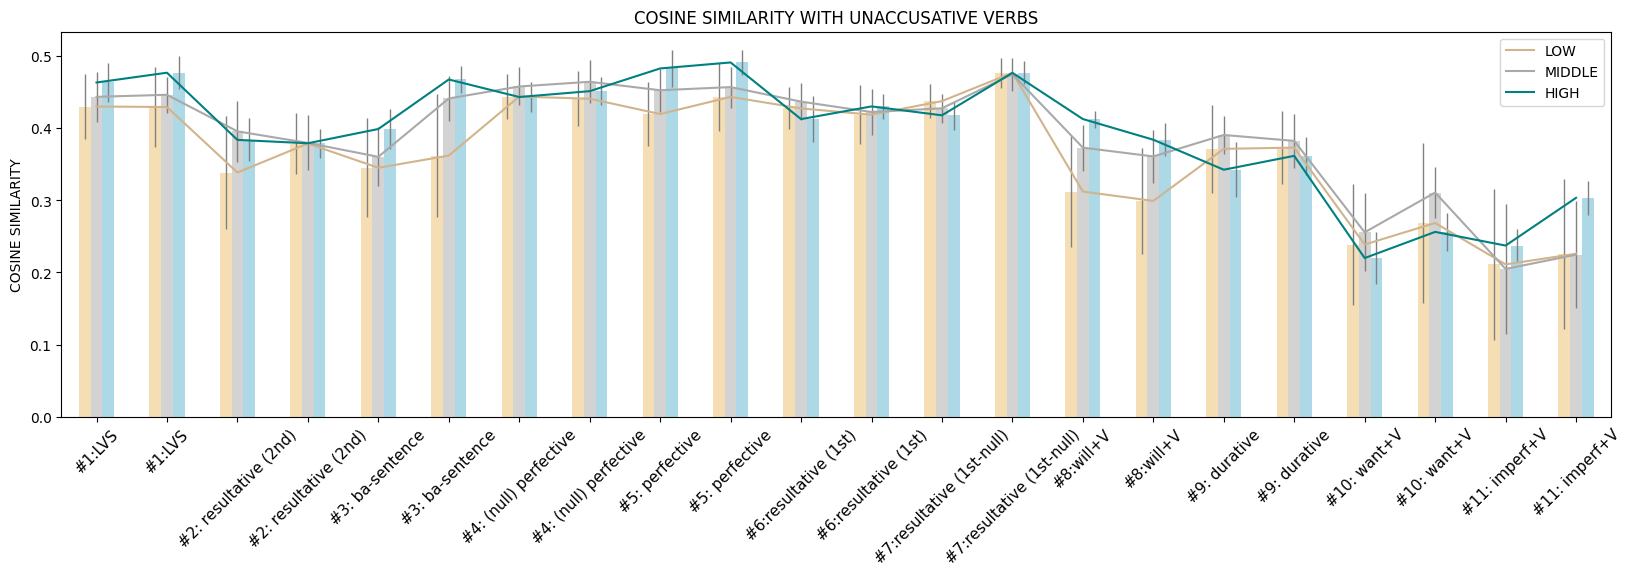

In [ ]:
# Create pandas dataframe and save the cosine similaries loss in the previous steps to the dataframe
df=pd.DataFrame(np.array([final_verb_loss_mean_before, final_verb_mean_loss_middle, final_verb_mean_loss_after]),
                 columns=['#1:LVS', '#1:LVS','#2: resultative (2nd)', '#2: resultative (2nd)','#3: ba-sentence', '#3: ba-sentence',
                          '#4: (null) perfective', '#4: (null) perfective', '#5: perfective', '#5: perfective',
                          '#6:resultative (1st)', '#6:resultative (1st)',
                          '#7:resultative (1st-null)','#7:resultative (1st-null)',
                          '#8:will+V','#8:will+V','#9: durative','#9: durative','#10: want+V', '#10: want+V','#11: imperf+V', '#11: imperf+V'])
df = df.T
df.columns = ['LOW', 'MIDDLE', 'HIGH']
#sort the verb types based on the indexes of constructions
df.index=pd.Categorical(df.index,categories=['#1:LVS','#2: resultative (2nd)','#3: ba-sentence', '#4: (null) perfective', '#5: perfective','#6:resultative (1st)','#7:resultative (1st-null)',
                                              '#8:will+V', '#9: durative','#10: want+V',  '#11: imperf+V'])
df=df.sort_index()
# append standard deviations to a list and plot the error bars
std=[]
std.append(std_before)
std.append(std_middle)
std.append(std_after)
print(df)
# plot the cosine similarity losses (bar charts) and standard deviations (error bars)
ax=df.plot(kind='bar', use_index=True, figsize=(20, 5), legend=None, color = ['wheat', 'lightgray', 'lightblue'], yerr=std, error_kw=dict(ecolor='gray', lw=1, capthick=1))
df.plot(ax=ax, kind='line', use_index=True, figsize=(20, 5), color = ['tan','darkgray', 'teal'])
plt.xticks(np.arange(len(df.index)), df.index, fontsize=11, rotation=45)

#plt.xticks(df.index)
#plt.xlabel('type #')
plt.ylabel('COSINE SIMILARITY')
plt.title('COSINE SIMILARITY WITH UNACCUSATIVE VERBS')
# show legend
#plt.legend()

# show graph
plt.show()


The plot shows cosine similarity losses with attested unaccusative verbs. Our prediction is that verbs in type #3,4,8 are should have low loss than verbs in type #2,5,6,11. And verbs in type #1,7,9,10 should be in the middle and show intermediate similairty losses. This prediction is based on our knowledge of those constructions. Our result generally matches this prediction because the verb types on the right sides (#2,5,6,11) are generally higher than the left sides (#3,4,8) with statistical significant differences, forming a slope. Moreover, with more occurrences of each sentence (compare 'low', 'middle', and 'high' models, with statistical significant differences among models), this left-slanted slope becomes more obvious. This graph demonstrated our hypotheses at the beginning of the notebook.

[array([0.06196625, 0.05882915, 0.10436477, 0.06823559, 0.10515498,
       0.1246151 , 0.02644327, 0.03595178, 0.05868319, 0.04593845,
       0.04132516, 0.04090188, 0.02616113, 0.02976627, 0.06604478,
       0.07038974, 0.04154389, 0.0459152 , 0.05778611, 0.07972148,
       0.06794414, 0.08063475]), array([0.03834372, 0.0337552 , 0.0555229 , 0.04628168, 0.06223202,
       0.04749223, 0.02210028, 0.03115436, 0.03150167, 0.03268474,
       0.02327592, 0.03100696, 0.02782856, 0.02368936, 0.03140914,
       0.03618502, 0.03385504, 0.03777033, 0.04241583, 0.03457969,
       0.06667549, 0.04867334]), array([0.03638828, 0.02491424, 0.03707653, 0.02280008, 0.04038032,
       0.02331622, 0.0267981 , 0.02469586, 0.02452517, 0.01580777,
       0.03224359, 0.02166677, 0.01917258, 0.01400217, 0.01409786,
       0.01297794, 0.02538054, 0.01840009, 0.03524661, 0.02532734,
       0.02102341, 0.01429484])]


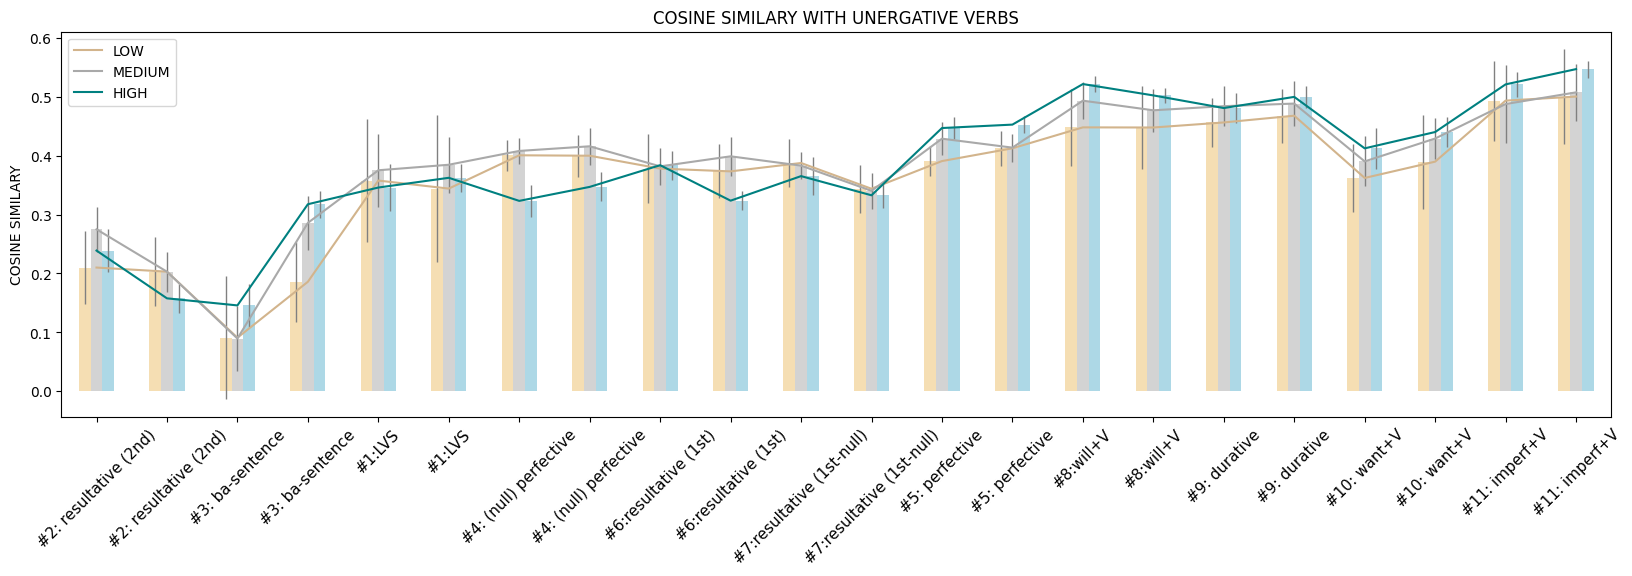

In [ ]:
# Create pandas dataframe and save the cosine similaries loss in the previous steps to the dataframe
df_asp=pd.DataFrame(np.array([final_verb_mean_loss_asp_before, final_verb_mean_loss_asp_middle, final_verb_mean_loss_asp_after]),
                 columns=['#1:LVS', '#1:LVS','#2: resultative (2nd)', '#2: resultative (2nd)','#3: ba-sentence', '#3: ba-sentence',
                          '#4: (null) perfective', '#4: (null) perfective', '#5: perfective', '#5: perfective',
                          '#6:resultative (1st)', '#6:resultative (1st)',
                          '#7:resultative (1st-null)','#7:resultative (1st-null)',
                          '#8:will+V','#8:will+V','#9: durative','#9: durative','#10: want+V', '#10: want+V','#11: imperf+V', '#11: imperf+V'])
df_asp = df_asp.T
df_asp.columns = ['LOW', 'MEDIUM', 'HIGH']
#sort the verb types based on the properties of constructions
df_asp.index=pd.Categorical(df_asp.index,categories=['#2: resultative (2nd)','#3: ba-sentence', '#1:LVS', '#4: (null) perfective', '#6:resultative (1st)','#7:resultative (1st-null)','#5: perfective',
                                              '#8:will+V', '#9: durative','#10: want+V',  '#11: imperf+V'])
df_asp=df_asp.sort_index()

# append standard deviations to a list and plot the error bars
std_asp=[]
std_asp.append(std_asp_before)
std_asp.append(std_asp_middle)
std_asp.append(std_asp_after)
print(std_asp)
# plot the cosine similarity losses (bar charts) and standard deviations (error bars)
ax=df_asp.plot(kind='bar', use_index=True, figsize=(20, 5),  legend=None, color = ['wheat', 'lightgray', 'lightblue'], yerr=std_asp, error_kw=dict(ecolor='gray', lw=1, capthick=1))
df_asp.plot(ax=ax, kind='line', use_index=True, figsize=(20, 5), color = ['tan','darkgray', 'teal'])
plt.xticks(np.arange(len(df_asp.index)), df_asp.index, fontsize=11, rotation=45)

#plt.xticks(df.index)
#plt.xlabel('type #')
plt.ylabel('COSINE SIMILARY')
plt.title('COSINE SIMILARY WITH UNERGATIVE VERBS')
# show legend
#plt.legend()

# show graph
plt.show()


This graph shows cosine similarity losses with attested unergative verbs. Therefore the verb types on the left side, should be higher than the verbs types on the right side, contrarily to the above graph (with statistical significant differences). The graph basically shows the same trend, and with more occurrences of sentences (compare 'low', 'middle', and 'high' models, with statistical significant differences among models), the right-slanted slope becomes clearer. This result again desmontrated the hypotheses at the beginning of the notebook.